In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import pandas as pd
import csv
import glob
import math
import random

In [3]:
from audiomentations import Compose, Gain, AddGaussianNoise, TimeMask, AddShortNoises, PolarityInversion, AirAbsorption, RepeatPart, Shift, AdjustDuration

In [4]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def load_wav_8k_mono(filename):
    try:
        file_contents = tf.io.read_file(filename)
        wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)
        if sample_rate != 8000:
            wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=8000)
        wav = tf.squeeze(wav, axis=-1)
    except Exception as e:
        print(f"Invalid file: {filename} - {e}")
    return wav

In [6]:
sample_rate = 8000
mel_spec_length = 32000
frame_length = 256
frame_step = 128
mel_bins = 64
upper_edge = 4000
lower_edge = 0

In [7]:
def preprocess_mel(file_path, label):
    # load wav and make sure length is proper
    if isinstance(file_path, str):
        try:
            wav, label = load_wav_8k_mono(file_path)
        except Exception as e:
            print(f"Failed to load wav file at {file_path} - {e}")
    else:
        wav = file_path

    if len(wav) > 32000:
        wav = wav[:mel_spec_length]
    if len(wav) < 32000:
        try:
            zero_padding = tf.zeros([mel_spec_length] - tf.shape(wav), dtype=tf.float32)
            wav = tf.concat([zero_padding, wav], 0)
        except Exception as e:
            print(f"Failed to pad wav file at {file_path} - {e}")
    
    # create the spectrogram
    print("Wav Shape:", wav.shape)
    spectrogram = tf.signal.stft(wav, frame_length, frame_step, window_fn=tf.signal.hann_window)
    print("STFT Shape1:", spectrogram.shape)
    spectrogram = tf.abs(spectrogram)
    print("STFT Shape2:", spectrogram.shape)

    # create the mel filterbank
    spec_bins = frame_length // 2 + 1  # Derived from frame length
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        mel_bins,
        spec_bins,
        sample_rate,
        lower_edge,
        upper_edge,
    )
    print("Mel Filterbank Shape:", mel_filterbank.shape)
    
    # create the mel spectrogram
    mel_spectrogram = tf.matmul(spectrogram, mel_filterbank)
    print("Mel Spectrogram Shape1:", mel_spectrogram.shape)

    # add a dimension
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=2)
    print("Mel Spectrogram Shape2:", mel_spectrogram.shape)

    return mel_spectrogram, label

In [8]:
augment_pos = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.0),
    TimeMask(min_band_part=0.05, max_band_part=0.08, p=1.0),
    AddShortNoises(sounds_path=train_NEG,
                   min_snr_db=3.0, max_snr_db=30.0,
                   noise_rms="relative_to_whole_input",
                   min_time_between_sounds=2.0,
                   max_time_between_sounds=8.0,
                   noise_transform=PolarityInversion(),
                   p=0.0
                  ),
])

In [9]:
augment_neg = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.0),
    Gain(min_gain_db=-6.0, max_gain_db=6.0, p=0.5),
    TimeMask(min_band_part=0.05, max_band_part=0.08, p=1.0),
    AddShortNoises(sounds_path=train_NEG,
                   min_snr_db=3.0, max_snr_db=30.0,
                   noise_rms="relative_to_whole_input",
                   min_time_between_sounds=2.0,
                   max_time_between_sounds=8.0,
                   noise_transform=PolarityInversion(),
                   p=0.0
                  ),
])

In [10]:
augment_val = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.0),
])

In [11]:
def augment_pos_wav(wav_tensor):
    # wav_numpy = wav_tensor.numpy()
    augmented_wav = augment_pos(samples=wav_tensor, sample_rate=8000)
    augmented_wav = tf.convert_to_tensor(augmented_wav, dtype=tf.float32)
    return augmented_wav

In [12]:
def augment_neg_wav(wav_tensor):
    # wav_numpy = wav_tensor.numpy()
    augmented_wav = augment_neg(samples=wav_tensor, sample_rate=8000)
    augmented_wav = tf.convert_to_tensor(augmented_wav, dtype=tf.float32)
    return augmented_wav

In [13]:
def augment_val_wav(wav_tensor):
    # wav_numpy = wav_tensor.numpy()
    augmented_wav = augment_val(samples=wav_tensor, sample_rate=8000)
    augmented_wav = tf.convert_to_tensor(augmented_wav, dtype=tf.float32)
    return augmented_wav

In [14]:
def load_and_augment_pos_wav_tf(filename):
    # Loads and augments gunshot wavs with tensorflow, calling respective audiomentation functions
    wav = load_wav_8k_mono(filename)
    augmented_wav = tf.numpy_function(func=augment_pos_wav, inp=[wav], Tout=tf.float32)
    return augmented_wav

In [15]:
def load_and_augment_neg_wav_tf(filename):
    # Loads and augments background wavs with tensorflow, calling respective audiomentation functions
    wav = load_wav_8k_mono(filename)
    augmented_wav = tf.numpy_function(func=augment_neg_wav, inp=[wav], Tout=tf.float32)
    return augmented_wav

In [16]:
def load_and_augment_val_wav_tf(filename):
    # Loads and augments val wavs with tensorflow, calling zero audiomentation functions
    wav = load_wav_8k_mono(filename)
    augmented_wav = tf.numpy_function(func=augment_val_wav, inp=[wav], Tout=tf.float32)
    return augmented_wav

In [17]:
def load_and_augment_val_wav_tf_tuple(filename, label):
    # Loads and augments val wavs with tensorflow, calling zero audiomentation functions
    wav = load_wav_8k_mono(filename)
    augmented_wav = tf.numpy_function(func=augment_val_wav, inp=[wav], Tout=tf.float32)
    return augmented_wav, label

In [18]:
def load_and_augment_pos_wav_tf_tuple(filename, label):
    # Loads and augments val wavs with tensorflow, calling zero audiomentation functions
    wav = load_wav_8k_mono(filename)
    augmented_wav = tf.numpy_function(func=augment_pos_wav, inp=[wav], Tout=tf.float32)
    return augmented_wav, label

In [19]:
def load_wav_tuple(filename, label):
    wav = load_wav_8k_mono(filename)
    return wav, label

In [2]:
test_csv = os.path.join('belize-data', 'b_test_files_and_labels.csv')
val_csv = os.path.join('belize-data', 'b_val_files_and_labels.csv')
val_NEG = os.path.join('belize-data', 'Validation data', 'Background')
val_POS = os.path.join('belize-data', 'Validation data', 'Gunshot')
train_NEG = os.path.join('belize-data', 'Training data', 'Background')
train_POS = os.path.join('belize-data', 'Training data', 'Gunshot')
neg_inject = os.path.join('neg_inject')

model_save_dir = os.path.join('model','model_exports')

In [20]:
def create_arr_from_csv(csv_filepath):
    with open(csv_filepath, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
        data = data[1:]
    return data

In [21]:
def change_label_type(filename, label):
    label = int(label)
    label = tf.cast(label, tf.float32)
    return filename, label

In [22]:
def prepare_valdata_csv(csv_filepath):
    data = create_arr_from_csv(csv_filepath)
    
    data = np.array(data)
    filenames = data[:,0]
    labels = data[:,1].astype(int)
    
    data = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    data = data.map(load_and_augment_val_wav_tf_tuple)
    data = data.map(change_label_type)
    data = data.map(preprocess_mel)
    return data

-------------------------------------------

In [26]:
train_pos = glob.glob(train_POS+'/*.wav')
train_neg_temp = glob.glob(train_NEG+'/*.wav')

#upsample train_pos
print(f'Train pos length before upsampling: {len(train_pos)}')
print(f'Train neg length: {len(train_neg_temp)}')
train_pos = train_pos*(math.floor(len(train_neg_temp)/len(train_pos)))
train_pos.extend(train_pos[:((len(train_neg_temp))%(len(train_pos)))])
print(f'Train pos length after upsampling: {len(train_pos)}')

# preprocess val pos
train_pos = tf.data.Dataset.from_tensor_slices((train_pos, [1]*(len(train_pos))))
train_pos = train_pos.map(change_label_type)
train_pos = train_pos.map(load_wav_tuple)
train_pos = train_pos.map(preprocess_mel)

# preprocess train neg
train_neg = tf.data.Dataset.list_files(train_NEG+'/*.wav')
train_neg = train_neg.map(load_wav_8k_mono)
train_neg = tf.data.Dataset.zip((train_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(train_neg)))))
train_neg = train_neg.map(preprocess_mel)

train_data = train_pos.concatenate(train_neg)

Train pos length before upsampling: 597
Train neg length: 28193
Train pos length after upsampling: 28193
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>


In [27]:
# preprocess val pos
val_pos = tf.data.Dataset.list_files(val_POS+'/*.wav')
val_pos = val_pos.map(load_wav_8k_mono)
val_pos = tf.data.Dataset.zip((val_pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(val_pos)))))
val_pos = val_pos.map(preprocess_mel)

# preprocess val neg
val_neg = tf.data.Dataset.list_files(val_NEG+'/*.wav')
val_neg = val_neg.map(load_wav_8k_mono)
val_neg = tf.data.Dataset.zip((val_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(val_neg)))))
val_neg = val_neg.map(preprocess_mel)

# join datasets
val_data = val_pos.concatenate(val_neg)

Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>


In [28]:
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=(len(train_data)+1))
train_data = train_data.batch(128)
train_data = train_data.prefetch(8)
train = train_data

In [29]:
val_data = val_data.cache()
val_data = val_data.shuffle(buffer_size=(len(val_data)+1))
val_data = val_data.batch(128)
val_data = val_data.prefetch(8)
val = val_data

----------------------------------------------

In [29]:
train_small = train.take(36)
val_subset = train.skip(36).take(15)

In [30]:
len(train)

441

In [31]:
len(val)

57

In [40]:
len(train_small)

36

In [51]:
for batch in train_small.take(1):
    print(batch)

(<tf.Tensor: shape=(16, 249, 64, 1), dtype=float32, numpy=
array([[[[0.26087654],
         [0.2517355 ],
         [0.00300037],
         ...,
         [0.03704636],
         [0.02794188],
         [0.02905342]],

        [[0.25940454],
         [0.25015768],
         [0.00119173],
         ...,
         [0.01881473],
         [0.0339442 ],
         [0.02414957]],

        [[0.26357332],
         [0.2543687 ],
         [0.0033831 ],
         ...,
         [0.01631916],
         [0.02532245],
         [0.02465568]],

        ...,

        [[0.2615464 ],
         [0.2532186 ],
         [0.01253245],
         ...,
         [0.03414609],
         [0.03267826],
         [0.025105  ]],

        [[0.2614805 ],
         [0.25352886],
         [0.01678792],
         ...,
         [0.04190835],
         [0.03010277],
         [0.03837941]],

        [[0.25849655],
         [0.24962611],
         [0.00510388],
         ...,
         [0.02053775],
         [0.03629862],
         [0.02889166]]],


 

In [56]:
def take_element_and_label(dataset):
    for batch, labels in dataset.take(1):
        singular_element = batch[0]
        singular_label = labels[0]
    return singular_element, singular_label

1.0
(249, 64, 1)


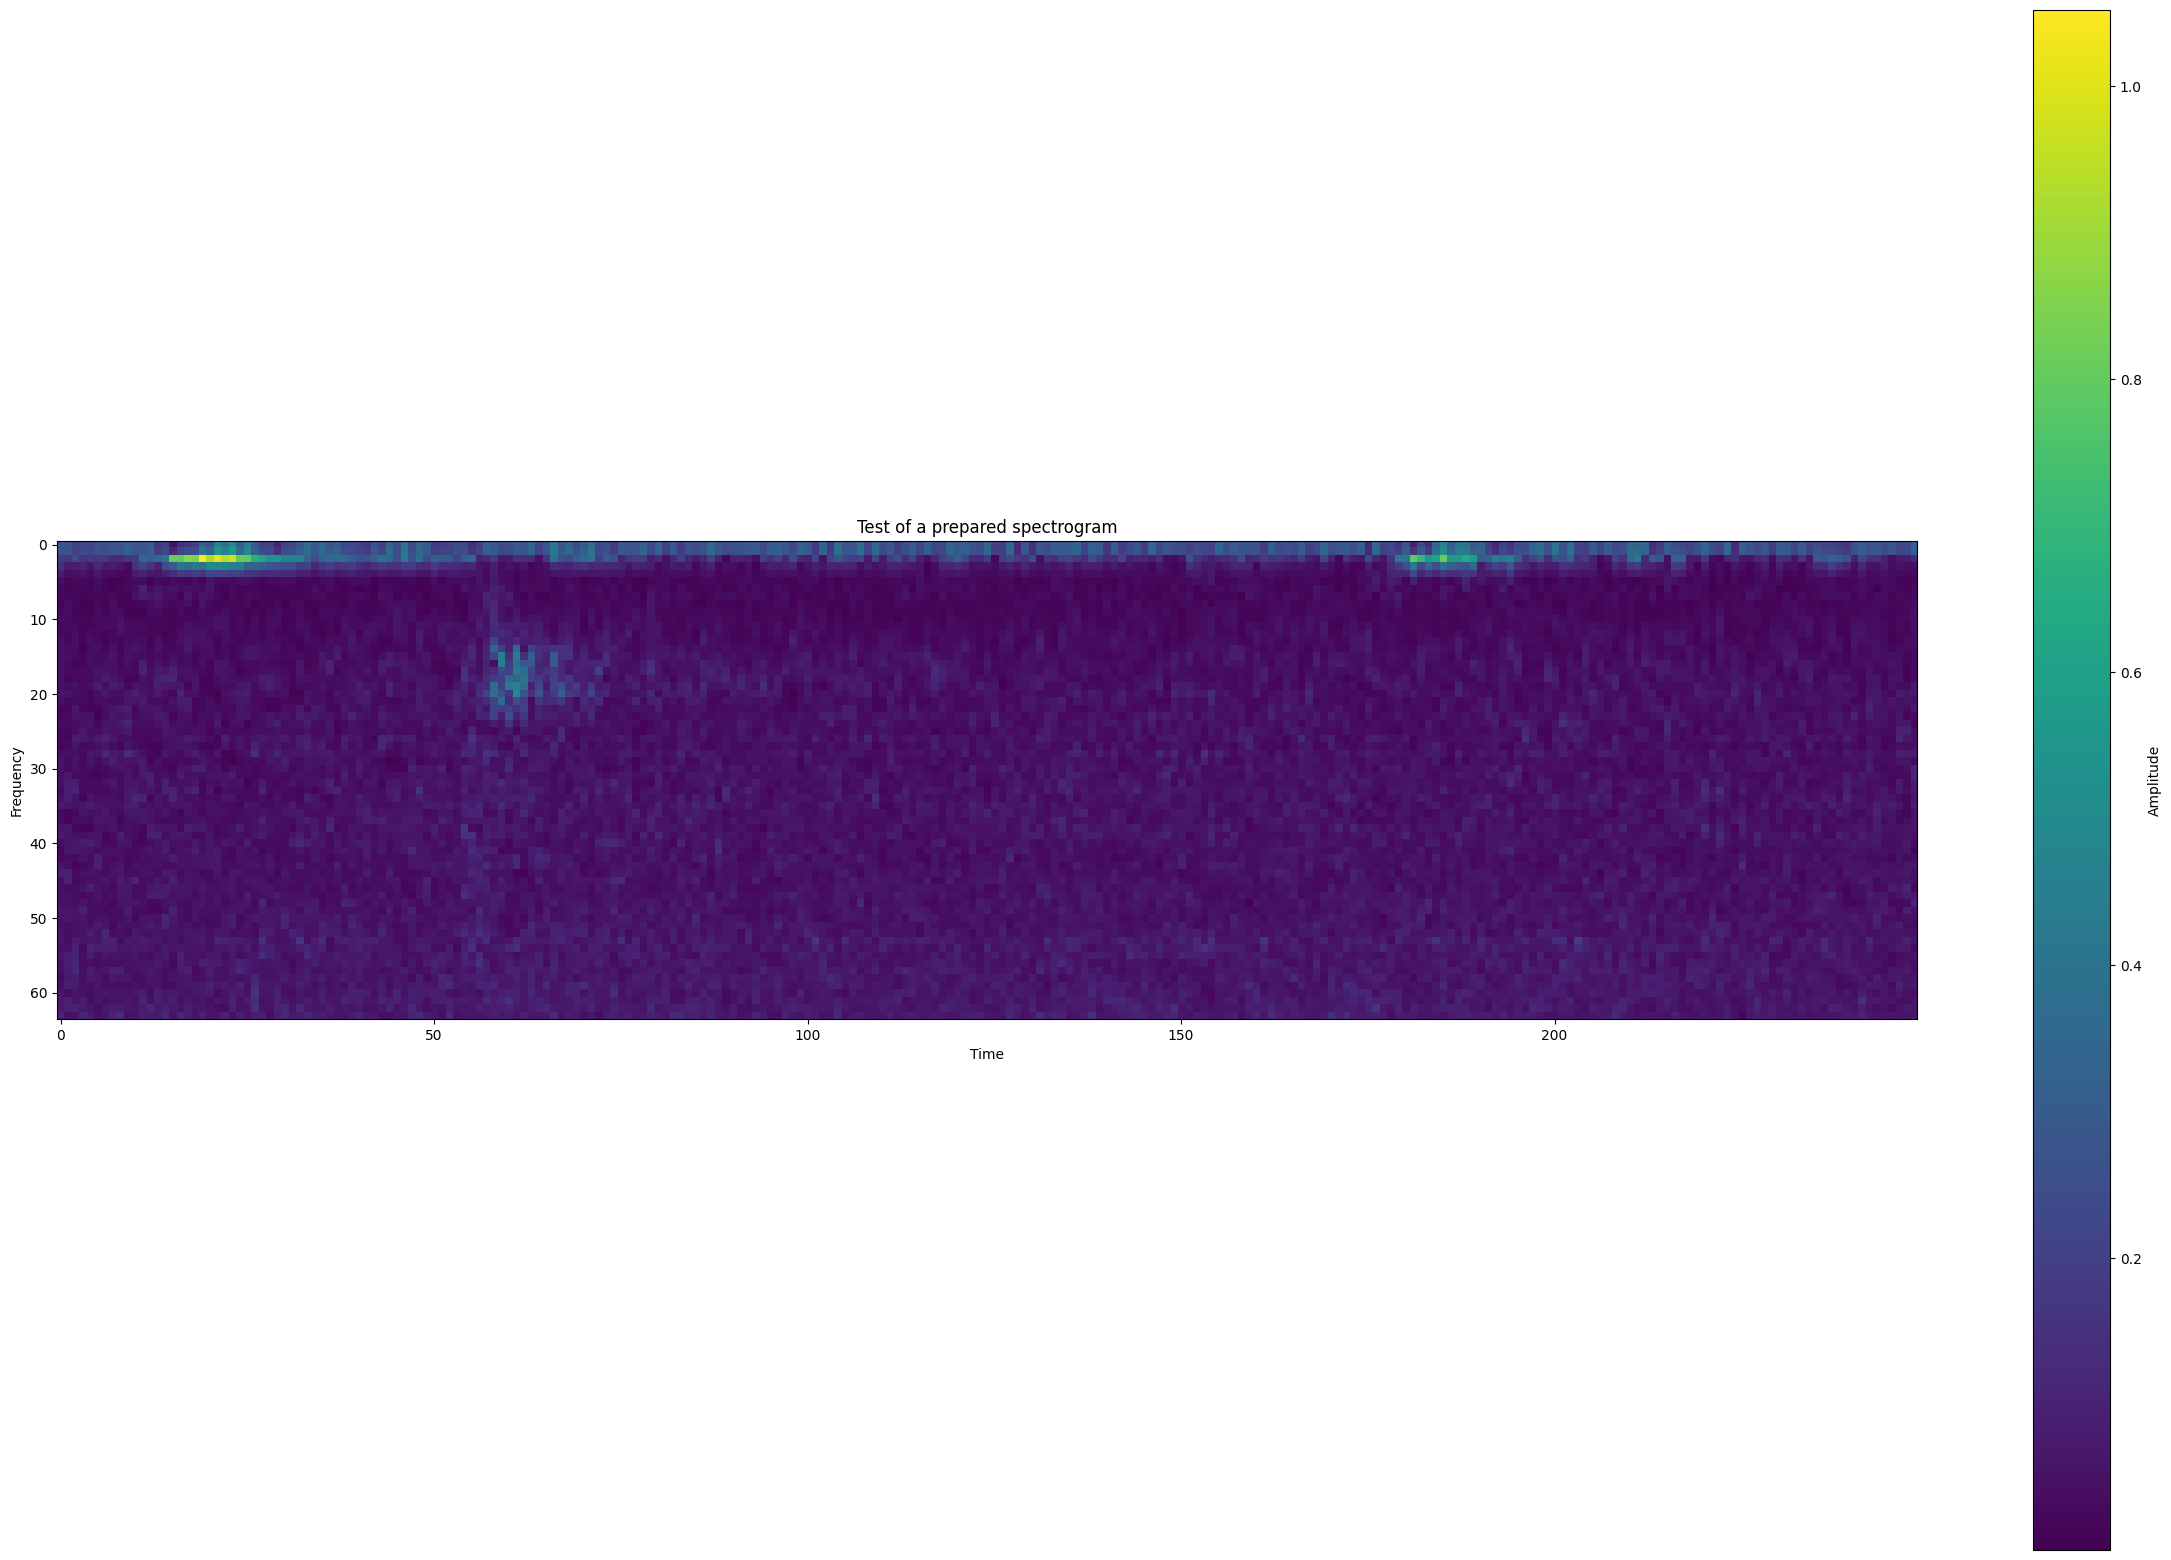

In [64]:
singular_element, singular_label = take_element_and_label(train_small)
print(singular_label.numpy())
prepared_spectrogram = singular_element
# prepared_spectrogram = tf.squeeze(singular_element, axis=-1)
print(prepared_spectrogram.shape)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(prepared_spectrogram)[0])
plt.colorbar(label="Amplitude")
plt.title("Test of a prepared spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

---------------


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint

In [33]:
from tensorflow import keras
import keras_tuner
from tensorflow.keras import layers, regularizers
from tensorflow.keras.regularizers import l2

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(249, 64, 1)))
model.add(Dropout(0.1))
model.add(Conv2D(16, (3,3), activation='relu', kernel_regularizer=l2(0.005)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.005)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.BinaryAccuracy()])

model.summary()

In [34]:
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(249, 64, 1)))
model.add(Conv2D(16, (3,3), activation='relu', kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 247, 62, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 245, 60, 16)       2320      
                                                                 
 dropout (Dropout)           (None, 245, 60, 16)       0         
                                                                 
 flatten (Flatten)           (None, 235200)            0         
                                                                 
 dense (Dense)               (None, 128)               30105728  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [36]:
hist = model.fit(train, epochs=4, validation_data=val)

Epoch 1/4


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/dense/MatMul/MatMul_1' defined at (most recent call last):
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\foxir\AppData\Local\Temp\ipykernel_16248\3189035676.py", line 1, in <module>
      hist = model.fit(train, epochs=4, validation_data=val)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\keras\engine\training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\foxir\miniconda3\envs\gunshot_tf\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential/dense/MatMul/MatMul_1'
OOM when allocating tensor with shape[235200,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/dense/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6884]

#### 5:17PM 1/19/25 --> Added regularization, seemed better for the first two epochs, but still signs of overfit

Val loss grew after 2nd epoch, making val recall decrease and val precision increase as everything got better on training

##### Data preparation
upsample train_pos
load_wav_8k_mono
preprocess_mel

train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=(len(train_data)+1))
train_data = train_data.batch(64)
train_data = train_data.prefetch(8)
train = train_data

val_data = val_data.cache()
val_data = val_data.shuffle(buffer_size=(len(val_data)+1))
val_data = val_data.batch(64)
val_data = val_data.prefetch(8)
val = val_data

no augmentation

##### Evaluation

Epoch 1/4
882/882 [==============================] - 170s 192ms/step - loss: 0.0933 - recall_1: 0.9746 - precision_1: 0.9630 - val_loss: 0.0820 - val_recall_1: 0.5467 - val_precision_1: 0.7069

Epoch 2/4
882/882 [==============================] - 164s 186ms/step - loss: 0.0084 - recall_1: 0.9991 - precision_1: 0.9979 - val_loss: 0.0783 - val_recall_1: 0.6067 - val_precision_1: 0.7712

Epoch 3/4
882/882 [==============================] - 168s 190ms/step - loss: 0.0064 - recall_1: 0.9991 - precision_1: 0.9984 - val_loss: 0.1084 - val_recall_1: 0.5533 - val_precision_1: 0.7905

Epoch 4/4
882/882 [==============================] - 165s 187ms/step - loss: 0.0033 - recall_1: 0.9995 - precision_1: 0.9991 - val_loss: 0.1809 - val_recall_1: 0.5067 - val_precision_1: 0.8837

##### model = Sequential()

model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(249, 64, 1)))
model.add(Conv2D(16, (3,3), activation='relu', kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

model.summary()

#### 4:52PM 1/19/25 --> Okay performance on the big-boy dataset, slight overfit, learning rate prob too high, prob increase batch size, then add augmentation

##### Data preparation
upsample train_pos
load_wav_8k_mono
preprocess_mel

train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=(len(train_data)+1))
train_data = train_data.batch(64)
train_data = train_data.prefetch(8)
train = train_data

val_data = val_data.cache()
val_data = val_data.shuffle(buffer_size=(len(val_data)+1))
val_data = val_data.batch(64)
val_data = val_data.prefetch(8)
val = val_data

no augmentation

##### Evaluation

Epoch 1/4
882/882 [==============================] - 721s 276ms/step - loss: 0.0341 - recall: 0.9960 - precision: 0.9888 - val_loss: 0.1301 - val_recall: 0.4667 - val_precision: 0.8861

Epoch 2/4
882/882 [==============================] - 148s 168ms/step - loss: 0.0061 - recall: 0.9992 - precision: 0.9986 - val_loss: 0.1319 - val_recall: 0.4933 - val_precision: 0.8605

Epoch 3/4
882/882 [==============================] - 142s 161ms/step - loss: 0.0020 - recall: 0.9999 - precision: 0.9997 - val_loss: 0.1642 - val_recall: 0.4533 - val_precision: 0.8947

Epoch 4/4
882/882 [==============================] - 146s 166ms/step - loss: 0.0011 - recall: 0.9999 - precision: 0.9998 - val_loss: 0.1660 - val_recall: 0.5067 - val_precision: 0.8941

##### model = Sequential()

model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(249, 64, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

model.summary()

#### 4:27PM 1/19/25 --> Good performance on the baby dataset, everything checks

train_small and val_subset (train_small=train.take(36), val_subset=train.skip(36).take(15))

no augmentation

Epoch 1/4
36/36 [==============================] - 205s 177ms/step - loss: 0.6228 - recall: 0.8238 - precision: 0.7210 - val_loss: 0.3801 - val_recall: 0.7533 - val_precision: 0.9079

Epoch 2/4
36/36 [==============================] - 6s 170ms/step - loss: 0.3311 - recall: 0.8616 - precision: 0.8593 - val_loss: 0.2684 - val_recall: 0.8722 - val_precision: 0.9519

Epoch 3/4
36/36 [==============================] - 6s 170ms/step - loss: 0.2184 - recall: 0.9381 - precision: 0.9224 - val_loss: 0.1889 - val_recall: 0.8898 - val_precision: 0.9625

Epoch 4/4
36/36 [==============================] - 6s 170ms/step - loss: 0.1374 - recall: 0.9710 - precision: 0.9404 - val_loss: 0.0899 - val_recall: 0.9698 - val_precision: 0.9825

##### model = Sequential()

model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(249, 64, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

model.summary()

#### 4:10PM 1/19/25

train_small and val_subset (train_small=train.take(36), val_subset=train.skip(36).take(15))

Epoch 1/4
36/36 [==============================] - 228s 277ms/step - loss: 2.2676 - recall: 0.2529 - precision: 0.5833 - binary_accuracy: 0.5430 - val_loss: 0.9174 - val_recall: 0.1772 - val_precision: 0.8235 - val_binary_accuracy: 0.5750

Epoch 2/4
36/36 [==============================] - 10s 265ms/step - loss: 1.0063 - recall: 0.7341 - precision: 0.6931 - binary_accuracy: 0.7010 - val_loss: 1.1133 - val_recall: 0.8214 - val_precision: 0.6932 - val_binary_accuracy: 0.7250

Epoch 3/4
36/36 [==============================] - 9s 257ms/step - loss: 1.0557 - recall: 0.8137 - precision: 0.6787 - binary_accuracy: 0.7070 - val_loss: 1.0039 - val_recall: 0.9636 - val_precision: 0.6608 - val_binary_accuracy: 0.7417

Epoch 4/4
36/36 [==============================] - 9s 259ms/step - loss: 1.0558 - recall: 0.7906 - precision: 0.6822 - binary_accuracy: 0.7161 - val_loss: 1.0017 - val_recall: 0.8635 - val_precision: 0.6246 - val_binary_accuracy: 0.6948

##### model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(249, 64, 1)))
model.add(Dropout(0.1))
model.add(Conv2D(16, (3,3), activation='relu', kernel_regularizer=l2(0.005)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.005)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.BinaryAccuracy()])

model.summary()

In [46]:
model.save('1-19-25,B-Dataset,Train_small/val_subset,30mPara,4E.keras', 'model_save_dir')